## Find all human miRNAs from families lost in mice and extract their miRBase id

In [15]:
import pandas as pd
from pathlib import Path
PROJECTDIR = Path('.').resolve().parents[2]

##########################################################################################################
# input
seedpath = '../data/hsa_seedinfo.txt'
lostfampath = f'{PROJECTDIR}/external_data/all_rodentlost_mirfams.list'
mirtarpath = '../data/miRTarBase_9_MTI.csv'

# output
figout = '../results/mirtarbase_targetgene_overlap_strongMTIonly_{}.png'
tableout = '../results/lost_human_targets_strongMTIonly_{}.tsv'
strong_MTI_only = True
##########################################################################################################


### Load mapping between MirGeneDB and miRBase IDs

In [16]:
def make_mirfam(string):
    fam = '-'.join(string.split('-')[1:3]).strip()
    return fam


def read_lostfams(path):
    with open(path, 'r') as fh:
        fams = fh.read().split('\n')
        fams.pop(-1)
    return fams


def extract_mirbase(df):
    outlist = []
    for value in df['mirbase'].values:
        value = value.strip()
        if value == 'None':
            continue
        value = value.replace('hsa-mir', 'miR')
        value = '-'.join(value.split('-')[:2])
        outlist.append(value)
    return outlist

seedf = pd.read_csv(seedpath, sep='\t', header=None)
seedf = seedf.filter([0, 1]).rename(columns={0: 'mirgene_id', 1: 'mirbase_id'})
seedf['mirgene_fam'] = seedf['mirgene_id'].apply(make_mirfam)
seedf['mirbase_id'] = seedf['mirbase_id'].str.replace('hsa-', '')
mapdf = seedf.filter(['mirbase_id', 'mirgene_fam'])
mapdf['mirbase_id'] = mapdf['mirbase_id'].str.strip()


#### Find miRBase IDs of lost miRNAs

In [17]:
lostfams = read_lostfams(lostfampath)

lasfam_map = mapdf[mapdf.mirgene_fam.isin(lostfams)].drop_duplicates()
display(lasfam_map.head())

,mirbase_id,mirgene_fam
241,mir-197,Mir-197
387,mir-489,Mir-489
398,mir-506,Mir-506
399,mir-507,Mir-506
400,mir-508,Mir-506


## Find MirTarBase targets of lost miRNAs

#### Read MirTarBase

In [18]:
dtypes = {
    'miRTarBase ID': 'str',
    'miRNA': 'str',
    'Species (miRNA)': 'str',
    'Target Gene': 'str',
    'Target Gene (Entrez ID)': 'int',
    'Species (Target Gene)': 'str',
    'Experiments': 'str',
    'Support Type': 'str',
    'References (PMID)': 'int',
}

tdf = pd.read_csv(mirtarpath, sep='\t', dtype=dtypes)

human_targets = tdf[tdf['Species (Target Gene)'] == 'Homo sapiens']

# with open('../data/mirtarbase_human_background.txt', 'w') as of:
#     for target_gene in human_targets['Target Gene'].unique():
#         of.write(target_gene + '\n')

# with open('../data/entrez_mirtarbase_human_background.txt', 'w') as of:
#     for target_gene in human_targets['Target Gene (Entrez ID)'].unique():
#         of.write(str(target_gene) + '\n')


# display(human_targets)
if strong_MTI_only:
    human_targets = human_targets[human_targets['Support Type'] == 'Functional MTI']


In [19]:
#lost_mirbase = ['hsa-' + mirid.replace('mir', 'miR') for mirid in lasfam_map.mirbase_id]


def mirbase2fam(x):
    return '-'.join(x.replace('miR', 'mir').split('-')[1:3])
    
human_targets['mirbase_fam'] = human_targets.miRNA.apply(mirbase2fam)


lost_human_targets = human_targets[human_targets.mirbase_fam.isin(lasfam_map.mirbase_id)]
lost_human_targets = lost_human_targets.rename(columns={'mirbase_fam': 'mirbase_id'})
lost_human_targets = lost_human_targets.merge(lasfam_map)
lost_human_targets = lost_human_targets.rename(columns={'mirbase_id': 'mirbase_fam'})
display(lost_human_targets)

display(lost_human_targets.mirbase_fam.unique())
display(len(lost_human_targets.mirbase_fam.unique()))

,miRTarBase ID,miRNA,Species (miRNA),Target Gene,Target Gene (Entrez ID),Species (Target Gene),Experiments,Support Type,References (PMID),mirbase_fam,mirgene_fam
0,MIRT000473,hsa-miR-1296-5p,Homo sapiens,MCM2,4171,Homo sapiens,qRT-PCR//Western blot,Functional MTI,20332239,mir-1296,Mir-1296
1,MIRT001979,hsa-miR-510-5p,Homo sapiens,HTR3E,285242,Homo sapiens,Luciferase reporter assay,Functional MTI,18614545,mir-510,Mir-506
2,MIRT003549,hsa-miR-489-3p,Homo sapiens,PTPN11,5781,Homo sapiens,Luciferase reporter assay//Western blot,Functional MTI,20700123,mir-489,Mir-489
3,MIRT003549,hsa-miR-489-3p,Homo sapiens,PTPN11,5781,Homo sapiens,Luciferase reporter assay,Functional MTI,26918448,mir-489,Mir-489
4,MIRT004198,hsa-miR-197-3p,Homo sapiens,FOXO3,2309,Homo sapiens,Microarray//qRT-PCR//Western blot,Functional MTI,26540468,mir-197,Mir-197
...,...,...,...,...,...,...,...,...,...,...,...
80,MIRT734670,hsa-miR-885-5p,Homo sapiens,CTNNB1,1499,Homo sapiens,Immunohistochemistry//In situ hybridization//L...,Functional MTI,27738331,mir-885,Mir-885
81,MIRT734716,hsa-miR-892a,Homo sapiens,CD226,10666,Homo sapiens,Luciferase reporter assay//qRT-PCR//Western blot,Functional MTI,27883251,mir-892a,Mir-506
82,MIRT734725,hsa-miR-506-3p,Homo sapiens,PIM3,415116,Homo sapiens,Luciferase reporter assay//qRT-PCR//Western blot,Functional MTI,26238203,mir-506,Mir-506
83,MIRT734874,hsa-miR-506-3p,Homo sapiens,FLOT1,10211,Homo sapiens,Luciferase reporter assay//qRT-PCR,Functional MTI,25793370,mir-506,Mir-506


array(['mir-1296', 'mir-510', 'mir-489', 'mir-197', 'mir-892b', 'mir-885',
       'mir-506', 'mir-1908', 'mir-513b', 'mir-508', 'mir-513c',
       'mir-766', 'mir-888', 'mir-769', 'mir-892a'], dtype=object)

15

#### Count overlap

In [20]:
from collections import Counter

fil4count = lost_human_targets.filter(['Target Gene', 'mirbase_fam']).drop_duplicates()

target_count = Counter(fil4count['Target Gene'])

for target_gene, count in target_count.items():
    if count > 1:
        print(target_gene)


SNAI2
GNG13
DR1
BTG3
CTNNB1


#### Randomly sample distributions

* Randomly generate sets of miRNAs (N=24)
* Determine distribution of overlap
* Plot against observed

In [21]:
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_mirbase_fams = sorted(human_targets.mirbase_fam.unique())
N = len(lost_human_targets.mirbase_fam.unique())
enrich_df = human_targets.filter(['Target Gene', 'mirbase_fam']).drop_duplicates()


random_overlap = []
for i in range(1000):
    random_mirfams = rd.sample(all_mirbase_fams, N)

    random_targets = human_targets[human_targets.mirbase_fam.isin(random_mirfams)]

    overlap = dict(Counter(random_targets['Target Gene'])).values()
    random_overlap.append(overlap)


#### Plot

[19, 1, 1, 2, 6]


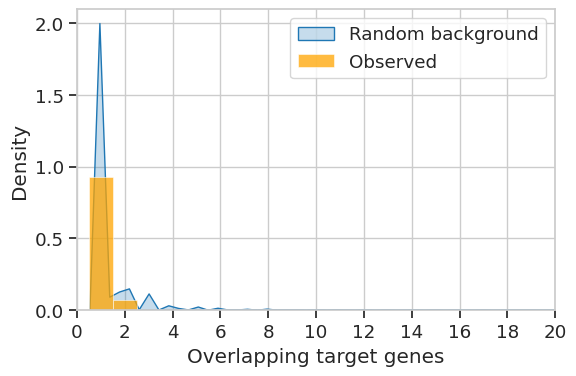

In [22]:
concat_random = [element for nestedlist in random_overlap for element in nestedlist]
print(concat_random[:5])

sns.set(rc={'figure.figsize':(6,4), 'ytick.left': True, 'xtick.bottom': True}, font_scale = 1.2, style='whitegrid')
sns.kdeplot(concat_random, fill=True, color='tab:blue', label='Random background', common_norm=True)
tc_array = np.array(list(target_count.values()), dtype=int)


sns.histplot(tc_array, color='orange', stat="density", discrete=True, label='Observed')
plt.xlim([0, 20])
plt.xlabel('Overlapping target genes')
plt.xticks(np.arange(0, 22, 2))
plt.legend()
plt.tight_layout()
plt.savefig(figout.format(strong_MTI_only), dpi=330)
plt.show()

## Statistics

* Mann-Whitney U test
* Compares two non-normal distributions (uses ranks)

The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [23]:
from scipy.stats import mannwhitneyu, wilcoxon

s, p = mannwhitneyu(tc_array, concat_random, alternative='greater')
print(s)
print(p)

6171397.0
0.9995000222663335


## List target genes of lost miRNAs for GO-Enrichment

In [1]:
display(lost_human_targets)

# with open(f'data/lostfam_mirtarbase_targetgenes_strongMTIonly_{strong_MTI_only}.txt', 'w') as of:
#     for targetgene in lost_human_targets['Target Gene'].unique():
#         of.write(targetgene + '\n')

# with open(f'data/Entrez_lostfam_mirtarbase_targetgenes_strongMTIonly_{strong_MTI_only}.txt', 'w') as of:
#     for targetgene in lost_human_targets['Target Gene (Entrez ID)'].unique():
#         of.write(str(targetgene) + '\n')
# print('done')


lost_human_targets.to_csv(tableout.format(strong_MTI_only), sep='\t', index=False)

NameError: name 'lost_human_targets' is not defined